In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asterion as ast
import arviz as az
import tinygp
from tinygp import kernels, GaussianProcess

ast.style.use("asterion-light")

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
numpyro.set_host_device_count(5)

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
df = pd.read_hdf('data/data.hdf5')
df["log_tau_he"] = np.log10(df["tau_he"])
df["log_tau_cz"] = np.log10(df["tau_cz"])
df['delta_tau'] = df['log_tau_cz'] / df['log_tau_he']
df["log_nu_max"] = np.log10(df["nu_max"])

m = 0.08/3
df['flag'] = df['delta_tau'] - (6*m + 1. - m * df['log_tau_he']) < 0
df.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,tau_he,delta_he,amp_he,tau_cz,dirname,log_tau_he,log_tau_cz,delta_tau,log_nu_max,flag
0,profile4,152.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,15247.850269,2037.139686,0.029961,38796.631185,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.183209,4.588794,1.096956,2.204462,False
1,profile5,153.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14809.891105,1980.528826,0.029540,37900.327592,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.170552,4.578643,1.097851,2.217565,False
2,profile6,154.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14496.838617,1940.585790,0.029221,37222.634389,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.161273,4.570807,1.098416,2.227690,False
3,profile7,155.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14220.559706,1878.217087,0.028561,36703.539749,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.152917,4.564708,1.099157,2.235572,False
4,profile8,156.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,0.8,...,14054.932771,1883.449431,0.028860,36302.082709,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1,4.147829,4.559932,1.099354,2.241746,False


In [3]:
df.loc[(df["frac_age"]>0.8261) & (df["frac_age"]<0.8262), "nu_max"]

8375      2304.216246
13539     2821.448614
76857     1999.886018
236133    1143.296327
Name: nu_max, dtype: float64

In [4]:
df.loc[~df["flag"], "effective_T"].max()

6920.1696244975965

In [5]:
from numpyro.infer import NUTS, MCMC
from jax import random

rng = random.PRNGKey(0)

INFO[2022-08-09 10:11:01,315]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-08-09 10:11:01,318]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-08-09 10:11:01,320]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [6]:
mask = (df['effective_T'] < 7000) & (df["frac_age"] > 0.01) & ~df["flag"] & (df["nu_max"] > 25.0)
# mask = (df['effective_T'] < 7000) & (df["frac_age"] > 0.01) & (df["nu_max"] > 25.0)
sample = df.loc[mask].sample(1000, ignore_index=True, weights="log_nu_max")
sample.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,tau_he,delta_he,amp_he,tau_cz,dirname,log_tau_he,log_tau_cz,delta_tau,log_nu_max,flag
0,profile834,1094.0,2.0,0.8,0.32,0.012086,0.0,2.3,0.0,0.799340,...,3125.848016,409.082229,0.017379,8890.206872,m0.8Y0.32FeH0.0MLT2.3ov0.0006666666666666673dif1,3.494968,3.948912,1.129885,2.873696,False
1,profile435,583.0,1.0,1.0,0.32,0.036806,0.5,2.3,0.0,1.000000,...,534.928815,70.734014,0.010430,1814.610602,m1.0Y0.32FeH0.5MLT2.3ov0.003555555555555556dif1,2.728296,3.258783,1.194439,3.629378,False
2,profile854,1124.0,2.0,1.4,0.28,0.038980,0.5,2.3,0.0,1.399649,...,2989.937455,412.458766,0.017752,9507.806680,m1.4Y0.28FeH0.5MLT2.3ov0.009333333333333329dif0,3.475662,3.978080,1.144553,2.893413,False
3,profile430,578.0,1.0,0.9,0.28,0.038970,0.5,2.1,0.0,0.900000,...,501.927754,46.221457,0.004889,1720.566703,m0.9Y0.28FeH0.5MLT2.1ov0.0021111111111111113dif1,2.700641,3.235672,1.198112,3.696522,False
4,profile527,675.0,1.0,1.2,0.24,0.013511,0.0,2.1,0.0,1.200000,...,779.263793,113.652011,0.014627,2045.906970,m1.2Y0.24FeH0.0MLT2.1ov0.006444444444444444dif0,2.891684,3.310886,1.144968,3.408477,False


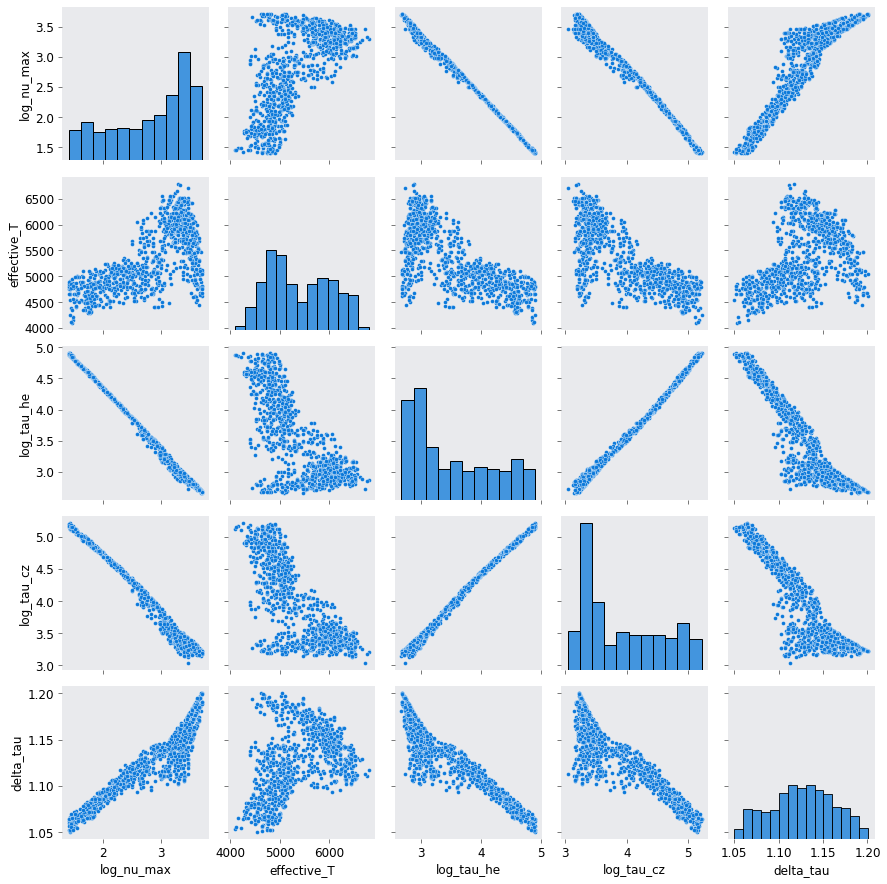

In [7]:
sns.pairplot(
    sample, 
    vars=['log_nu_max', 'effective_T', 'log_tau_he', 'log_tau_cz', 'delta_tau'], 
#     hue="effective_T",
);

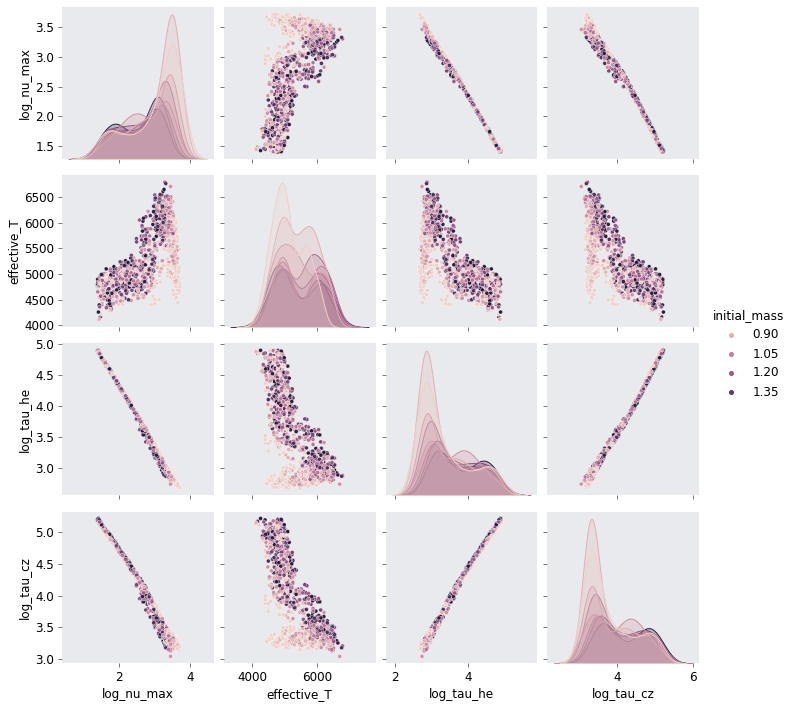

In [164]:
sns.pairplot(
    sample, 
    vars=['log_nu_max', 'effective_T', 'log_tau_he', 'log_tau_cz'], 
    hue="initial_mass",
);

In [165]:
df["dif"] = df["dirname"].apply(lambda x: x[-1]).astype(int)

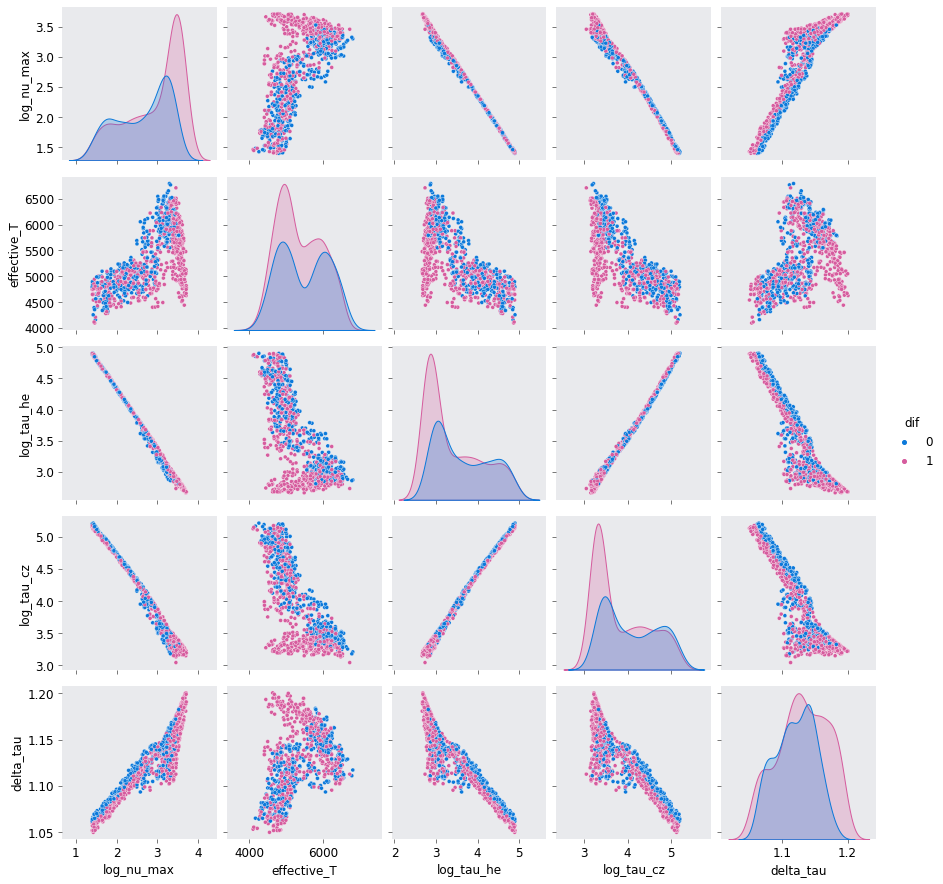

In [171]:
sns.pairplot(
    sample, 
    vars=['log_nu_max', 'effective_T', 'log_tau_he', 'log_tau_cz', 'delta_tau'], 
    hue="dif",
);

In [120]:
import zipfile
import gyraffe
from gyraffe.io import read_mesa_profile

In [61]:
path = "/Volumes/daviesgr-cartography/mesa_grid/grid2p5_zams_rgb_ov/grid_2p5"

def get_profile(idx, df):
    archive_name = os.path.join(path, df.loc[idx, "dirname"], "GYRE.zip")
    with zipfile.ZipFile(archive_name, 'r') as archive:
    #     print(archive.namelist()[0])
        with archive.open(os.path.join(df.loc[idx, "dirname"], df.loc[idx, "filename"] + ".data.GYRE")) as file:
    #         for i in range(10):
    #             prinxwt(file.readline())
            profile = read_mesa_profile(file)
    profile["c"] = gyraffe.sound_speed(profile)
    profile["tau"] = gyraffe.acoustic_depth(profile)
    return profile

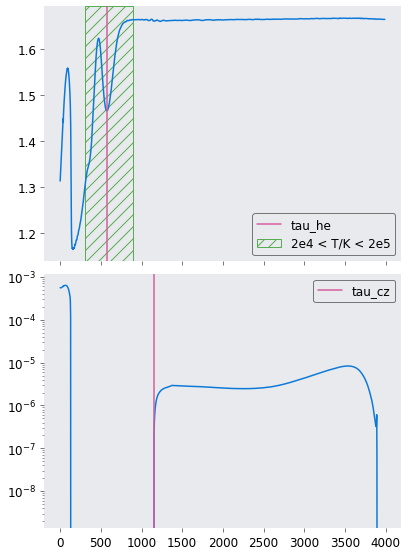

In [78]:
data = sample

idx = data["effective_T"].idxmax()
# idx = data.loc[(data["flag"]) & (data["frac_age"] > 0.01)].index[1000]
profile = get_profile(idx, data)

tau_he = data.loc[idx, "tau_he"]
tau_cz = data.loc[idx, "tau_cz"]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 9.6),
                               sharex=True, gridspec_kw={"hspace": 0.05})

ax1.plot(profile["tau"], profile["Gamma_1"])
ax1.axvline(tau_he, color="C1", label="tau_he")

ax1.axvspan(
    profile.loc[profile["T"] > 2e4, "tau"].iloc[-1],
    profile.loc[profile["T"] < 2e5, "tau"].iloc[0],
    facecolor="none",
    edgecolor="C2",
    hatch="//",
    label="2e4 < T/K < 2e5"
)
ax1.legend()
# ax1.grid(True)
ax2.plot(profile["tau"], profile["N^2"])
ax2.axvline(tau_cz, color="C1", label="tau_cz")

ax2.set_yscale("log")
ax2.legend();
# ax2.grid(True)

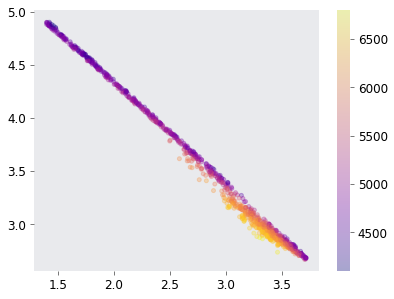

In [12]:
s = plt.scatter(sample["log_nu_max"], sample["log_tau_he"], alpha=0.3, c=sample["effective_T"])

plt.colorbar(s)

In [13]:
np.log10(1500)

3.1760912590556813

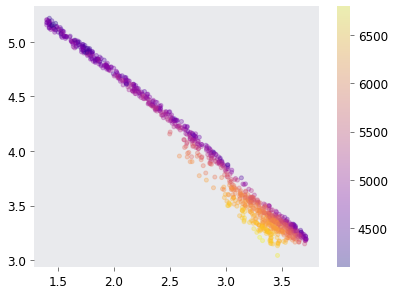

In [14]:
s = plt.scatter(sample["log_nu_max"], sample["log_tau_cz"], alpha=0.3, c=sample["effective_T"])

plt.colorbar(s)

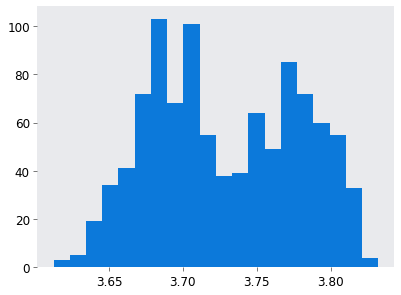

In [15]:
plt.hist(np.log10(sample["effective_T"]), bins=20);

In [16]:
from tinygp import transforms

In [256]:
def model(xy, obs=None, xy_test=None, diag=0.0):

#     beta = numpyro.sample("beta", dist.Normal(0.0, 10.0), sample_shape=(2,))
    
#     def mean(xy):
#         return beta[0] + beta[1] * xy[1]

    mu = numpyro.sample("mu", dist.Normal(0.0, 10.0))
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))
    
#     with numpyro.plate("kernel", 2):
#         var = numpyro.sample("var", dist.HalfNormal(1.0))
#         scale = numpyro.sample("scale", dist.HalfNormal(5.0*jnp.ones(2)), sample_shape=(2,))    
#         off_diag = numpyro.sample("off_diag", dist.HalfNormal(1.0))
 
    var = numpyro.sample("var", dist.HalfNormal(1.0))
    scale = numpyro.sample("scale", dist.HalfNormal(5.0*jnp.ones(2)))    
    off_diag = numpyro.sample("off_diag", dist.HalfNormal(1.0))
        
    kernel = var * transforms.Cholesky.from_parameters(
            scale, off_diag, kernels.ExpSquared()
    )
#     kernel = (
#         var[..., 0] * transforms.Cholesky.from_parameters(
#             scale[..., 0], off_diag[..., 0], kernels.ExpSquared()
#         )
#         + var[..., 1] * transforms.Cholesky.from_parameters(
#             scale[..., 1], off_diag[..., 1], kernels.ExpSquared()
#         )
#     )

    

    gp = GaussianProcess(kernel, xy,
                         diag=sigma**2,
                         mean=mu,
#                          mean=mean,
                        )
    
    z = numpyro.sample("z", gp.numpyro_dist(), obs=obs)
    
    if xy_test is not None:
        gp_cond = gp.condition(z, xy_test, diag=sigma**2 + diag).gp
        numpyro.deterministic("z_test_mean", gp_cond.mean)
        numpyro.deterministic("z_test_var", gp_cond.variance)
#         numpyro.sample("z_test", gp_cond.numpyro_dist())

### EXPERIMENTAL

In [242]:
@jax.vmap
def sample_gp(X, mu, sigma, var, scale, off_diag, obs=None):
    kernel = var * transforms.Cholesky.from_parameters(
            scale, off_diag, kernels.ExpSquared()
    )
    
    gp = GaussianProcess(kernel, X,
                         diag=sigma**2,
                         mean=mu,
                        )
    return numpyro.sample("z", gp.numpyro_dist(), obs=obs)

def model(X, y=None, X_test=None, diag=0.0):
    N = X.shape[0]
    
    with numpyro.plate("N", N):
        var = numpyro.sample("var", dist.HalfNormal(1.0))
        scale = numpyro.sample("scale", dist.HalfNormal(5.0*jnp.ones(2)))
        mu = numpyro.sample("mu", dist.Normal(0.0, 10.0))
        sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))
        off_diag = numpyro.sample("off_diag", dist.HalfNormal(1.0))
    
    sample_gp(X, mu, sigma, var, scale, off_diag)

In [173]:
guide = AutoDelta(model)
optim = Adam(0.01)
loss = Trace_ELBO()
svi = SVI(model, guide, optim, loss)

In [174]:
X = jnp.broadcast_to(jnp.log10(jnp.stack(
    [
        sample["effective_T"].to_numpy(),
        sample["nu_max"].to_numpy()
    ],
    axis=-1
)), (2, 1000, 2))

In [247]:
rng, key = random.split(rng)

svi_result = svi.run(key, 200, X, y=obs.T)

ValueError: Dimension mismatch: expected (ndim-1)*ndim/2 = 0 elements in 'off_diagonal'; got 1

### END EXPERIMENTAL

In [ ]:
# # Linear mixture model

# def model(nu_max, tau_obs=None):
#     a = numpyro.sample("a", dist.Normal(-1.0, 0.3), sample_shape=(2,))
#     b = numpyro.sample("b", dist.Normal(0.0, 0.5), sample_shape=(2,))
#     sigma_tau = numpyro.sample("sigma_tau", dist.HalfNormal(0.05), sample_shape=(2,))
    
#     mu_tau = a * nu_max[..., None] + b  # Two linear fits

#     loc = numpyro.sample("loc", dist.Normal(3.4, 0.2))
#     scale = numpyro.sample("scale", dist.HalfNormal(0.1))
    
#     # Prior prob of being on MS population
#     logp_ms = dist.Normal(loc, scale).log_prob(nu_max)
#     logp_rg = dist.Uniform(nu_max.min(), nu_max.max()).log_prob(nu_max)

#     tau_dist = dist.Normal(mu_tau, sigma_tau)

#     if tau_obs is not None:
#         # Add log likelihood
#         logL = tau_dist.log_prob(tau_obs[..., None])
#         logp_ms += logL[:, 0]
#         logp_rg += logL[:, 1]

#     logp_marg = jnp.logaddexp(logp_ms, logp_rg)
    
#     logp = logp_marg.sum()
#     numpyro.factor("logp", logp)
    
#     p_rg = numpyro.deterministic("p_rg", jnp.exp(logp_rg - logp_marg))
    
#     if tau_obs is None:
#         _tau = numpyro.sample("_tau", tau_dist)
#         idx = numpyro.sample("idx", dist.Bernoulli(probs=p_rg), infer={'enumerate': 'parallel'})
#         tau = numpyro.deterministic(
#             "tau",
#             jnp.squeeze(jnp.take_along_axis(_tau, idx[..., None], axis=1))
#         )


In [18]:
from numpyro.infer import Predictive

In [19]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.optim import Adam

In [257]:
guide = AutoDelta(model)
optim = Adam(0.1)
loss = Trace_ELBO()
svi = SVI(model, guide, optim, loss)

In [258]:
xy = jnp.log10(jnp.stack(
    [
        sample["effective_T"].to_numpy(),
        sample["nu_max"].to_numpy()
    ],
    axis=-1
))

In [259]:
rng, key = random.split(rng)

svi_result = svi.run(key, 200, xy, obs=sample["log_tau_he"].to_numpy() - 6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.28it/s, init loss: -1624.4414, avg. loss [191-200]: -2970.5320]


In [260]:
svi_result.params

{'mu_auto_loc': DeviceArray(-2.8055242, dtype=float64),
 'off_diag_auto_loc': DeviceArray(0.08594628, dtype=float64),
 'scale_auto_loc': DeviceArray([0.19506654, 2.65079129], dtype=float64),
 'sigma_auto_loc': DeviceArray(0.0116815, dtype=float64),
 'var_auto_loc': DeviceArray(1.71266786, dtype=float64)}

In [261]:
import jax

In [262]:
num_steps = 200

def run_svi(key, obs):
    return svi.run(key, num_steps, xy, obs=obs, progress_bar=False)

In [263]:
key = random.split(rng)

obs = jnp.stack([
    sample["log_tau_he"].to_numpy() - 6,
    sample["log_tau_cz"].to_numpy() - 6
])

svi_results = jax.vmap(run_svi)(key, obs)

In [264]:
svi_results.params

{'mu_auto_loc': DeviceArray([-2.8055242 , -2.16996008], dtype=float64),
 'off_diag_auto_loc': DeviceArray([0.08594628, 0.02155778], dtype=float64),
 'scale_auto_loc': DeviceArray([[0.19506654, 2.65079129],
              [0.08844784, 1.51465418]], dtype=float64),
 'sigma_auto_loc': DeviceArray([0.0116815 , 0.02215463], dtype=float64),
 'var_auto_loc': DeviceArray([1.71266786, 1.00371128], dtype=float64)}

In [265]:
x_grid, y_grid = jnp.linspace(jnp.array([3.6, 0.5]), jnp.array([3.9, 4.0]), 51, axis=1)
xx, yy = jnp.meshgrid(x_grid, y_grid)
xy_grid = jnp.stack([xx.flatten(), yy.flatten()], axis=-1)

In [266]:
def predict(key, params, obs, diag=0.0):
    predictive = Predictive(model, guide=guide, params=params, num_samples=1)
    return predictive(key, xy, obs=obs, xy_test=xy_grid, diag=diag)

In [267]:
key = random.split(rng)
pred = jax.vmap(predict)(key, svi_results.params, obs)

In [268]:
tau_grid = jnp.squeeze(pred["z_test_mean"]).reshape((2,) + xx.shape)
tau_grid.shape

(2, 51, 51)

In [269]:
sd_grid = jnp.sqrt(jnp.squeeze(pred["z_test_var"]).reshape((2,) + xx.shape))
sd_grid.shape

(2, 51, 51)

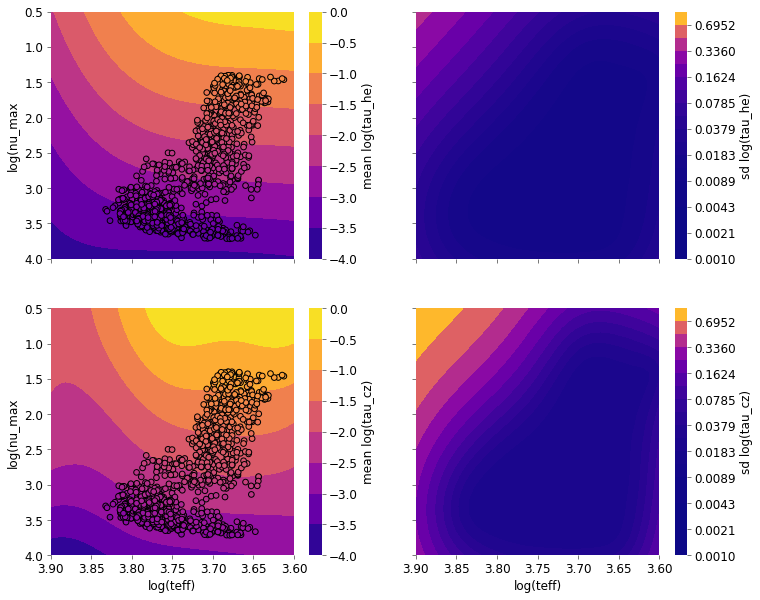

In [270]:
vmin = -4.0
vmax = 0.0

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
labels = ["he", "cz"]

for i in range(2):
    ax = axes[i, 0]
    c = ax.contourf(
        xx, 
        yy, 
        tau_grid[i],
        vmin=vmin,
        vmax=vmax
    )

    s = ax.scatter(
        np.log10(sample["effective_T"]), 
        np.log10(sample["nu_max"]), 
        c=obs[i],
        s=32,
        vmin=vmin,
        vmax=vmax,
        edgecolor="black"

    )
    ax.set_ylabel("log(nu_max")
    plt.colorbar(c, ax=ax, label=f"mean log(tau_{labels[i]})")
    
    if i == 1:
        axes[i, 0].set_xlabel("log(teff)")
        axes[i, 1].set_xlabel("log(teff)")
        
    ax = axes[i, 1]
    c = ax.contourf(
        xx, 
        yy, 
        sd_grid[i],
#         vmin=0.0,
#         vmax=0.1,
        levels=np.logspace(-3, 0, 20),
    )

    plt.colorbar(c, ax=ax, label=f"sd log(tau_{labels[i]})")
    
    
ax.invert_xaxis()
ax.invert_yaxis()

#     plt.colorbar(c)

In [271]:
test = df.loc[mask].sample(1000)

xy_test = jnp.log10(jnp.stack(
    [
        test["effective_T"].to_numpy(),
        test["nu_max"].to_numpy()
    ],
    axis=-1
))

def test_predict(key, params, obs, diag=0.0):
    predictive = Predictive(model, guide=guide, params=params, num_samples=1)
    return predictive(key, xy, obs=obs, xy_test=xy_test, diag=diag)

key = random.split(rng)
test_pred = jax.vmap(test_predict)(key, svi_results.params, obs)

In [272]:
test_true = jnp.stack([
    test["log_tau_he"].to_numpy() - 6,
    test["log_tau_cz"].to_numpy() - 6,
])
test_true.shape

(2, 1000)

In [274]:
err = abs(test_true - test_pred["z_test_mean"].squeeze())

(array([[559., 321.,  73.,  32.,  10.,   4.,   1.,   0.,   0.,   0.],
        [236., 259., 184., 145., 106.,  48.,  12.,   5.,   4.,   1.]]),
 array([2.44962764e-06, 7.65160796e-03, 1.53007663e-02, 2.29499246e-02,
        3.05990830e-02, 3.82482413e-02, 4.58973996e-02, 5.35465579e-02,
        6.11957163e-02, 6.88448746e-02, 7.64940329e-02]),
 <a list of 2 BarContainer objects>)

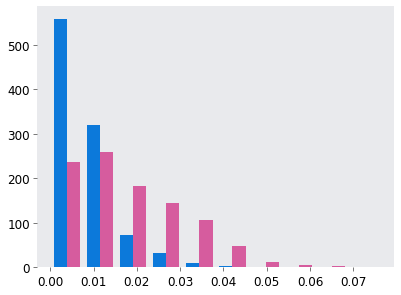

In [278]:
plt.hist(err)

## Z-score

looks good!

In [292]:
z_score = (test_true - test_pred["z_test_mean"].squeeze()) / jnp.sqrt(test_pred["z_test_var"]).squeeze()
z_score.shape

(2, 1000)

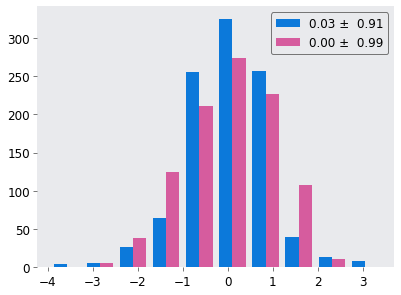

In [293]:
*_, lines = plt.hist(z_score)
plt.legend(lines, [f"{z.mean():.2f} ± {z.std(): .2f}" for z in z_score])

SD underestimated for He Z-score meaning that the GP variance is over-predicted, this should not be an issue.

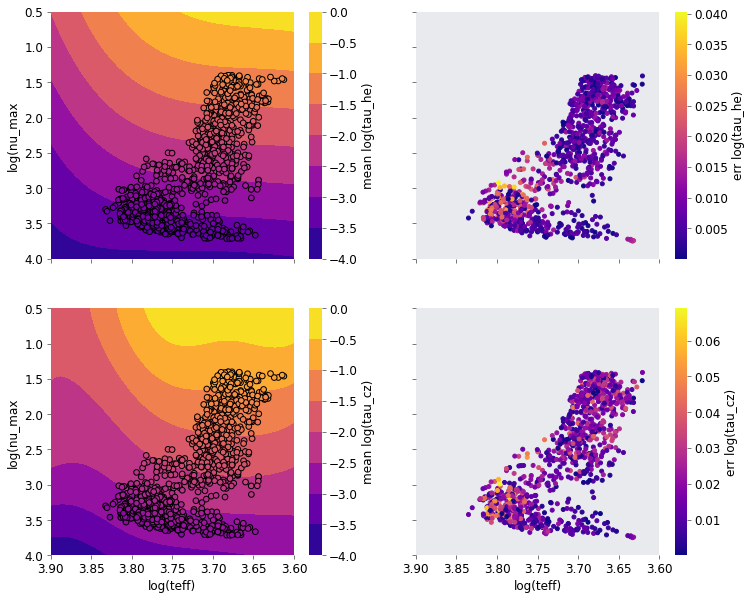

In [115]:
vmin = -4.0
vmax = 0.0

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
labels = ["he", "cz"]

for i in range(2):
    ax = axes[i, 0]
    c = ax.contourf(
        xx, 
        yy, 
        tau_grid[i],
        vmin=vmin,
        vmax=vmax
    )

    s = ax.scatter(
        np.log10(sample["effective_T"]), 
        np.log10(sample["nu_max"]), 
        c=obs[i],
        s=32,
        vmin=vmin,
        vmax=vmax,
        edgecolor="black"

    )
    ax.set_ylabel("log(nu_max")
    plt.colorbar(c, ax=ax, label=f"mean log(tau_{labels[i]})")
    
    if i == 1:
        axes[i, 0].set_xlabel("log(teff)")
        axes[i, 1].set_xlabel("log(teff)")
        
    ax = axes[i, 1]
    c = ax.scatter(
        *xy_test.T,
        c=err[i]
    )
    
    plt.colorbar(c, ax=ax, label=f"err log(tau_{labels[i]})")
    
    
ax.invert_xaxis()
ax.invert_yaxis()

#     plt.colorbar(c)

In [127]:
i = int(err[1].argmax())
test.iloc[i].name

204807

In [134]:
tau_cz_pred = test_pred["z_test_mean"][1].squeeze()
tau_cz_pred.shape

(1000,)

In [137]:
np.sqrt(test_pred["z_test_var"][1].squeeze()[i])

0.022407129680418345

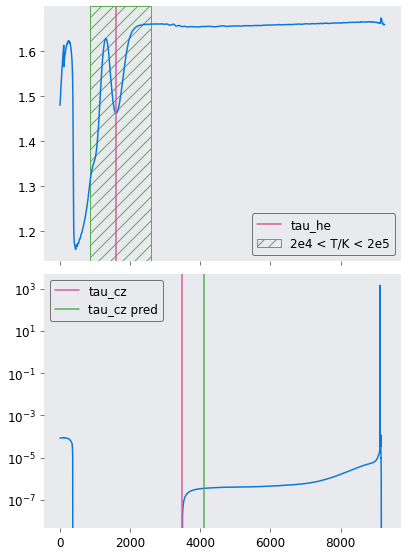

In [135]:
data = test

# idx = data["effective_T"].idxmax()
idx = data.iloc[int(err[1].argmax())].name
# idx = data.loc[(data["flag"]) & (data["frac_age"] > 0.01)].index[1000]
profile = get_profile(idx, data)

tau_he = data.loc[idx, "tau_he"]
tau_cz = data.loc[idx, "tau_cz"]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 9.6),
                               sharex=True, gridspec_kw={"hspace": 0.05})

ax1.plot(profile["tau"], profile["Gamma_1"])
ax1.axvline(tau_he, color="C1", label="tau_he")

ax1.axvspan(
    profile.loc[profile["T"] > 2e4, "tau"].iloc[-1],
    profile.loc[profile["T"] < 2e5, "tau"].iloc[0],
    facecolor="none",
    edgecolor="C2",
    hatch="//",
    label="2e4 < T/K < 2e5"
)
ax1.legend()
# ax1.grid(True)
ax2.plot(profile["tau"], profile["N^2"])
ax2.axvline(tau_cz, color="C1", label="tau_cz")


ax2.axvline(10**(tau_cz_pred[i] + 6), color="C2", label="tau_cz pred")
ax2.set_yscale("log")
ax2.legend();
# ax2.grid(True)

In [22]:
he_predictive = Predictive(model, guide=guide, params=svi_result.params, num_samples=1)

In [24]:
rng, key = random.split(rng)

grid_pred = he_predictive(key, xy, obs=sample["log_tau_he"].to_numpy() - 6, xy_test=xy_grid)

In [25]:
tau_grid = jnp.squeeze(grid_pred["z_test_mean"]).reshape(xx.shape)
tau_grid.shape

(51, 51)

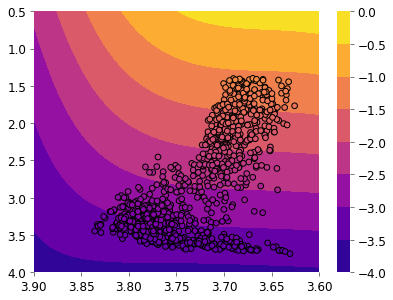

In [26]:
vmin = -4.0
vmax = 0.0

c = plt.contourf(
    xx, 
    yy, 
    tau_grid,
    vmin=vmin,
    vmax=vmax
)

s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["nu_max"]), 
    c=sample["log_tau_he"].to_numpy() - 6,
    s=32,
    vmin=vmin,
    vmax=vmax,
    edgecolor="black"
    
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(c)

In [27]:
test = df.loc[mask].sample(1000)

xy_test = jnp.log10(jnp.stack(
    [
        test["effective_T"].to_numpy(),
        test["nu_max"].to_numpy()
    ],
    axis=-1
))

In [28]:
rng, key = random.split(rng)

test_pred = he_predictive(key, xy, obs=sample["log_tau_he"].to_numpy() - 6, xy_test=xy_test)

In [29]:
tau_test_mean = jnp.squeeze(test_pred["z_test_mean"])
tau_test_var = jnp.squeeze(test_pred["z_test_var"])

(array([417., 341., 135.,  41.,  32.,  14.,   8.,   9.,   2.,   1.]),
 array([6.39767857e-05, 5.61195073e-03, 1.11599247e-02, 1.67078986e-02,
        2.22558726e-02, 2.78038465e-02, 3.33518205e-02, 3.88997944e-02,
        4.44477683e-02, 4.99957423e-02, 5.55437162e-02]),
 <BarContainer object of 10 artists>)

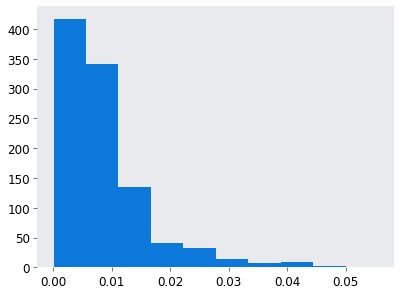

In [30]:
err = abs(tau_test_mean - test["log_tau_he"].to_numpy() + 6)

plt.hist(np.ravel(err))

In [44]:
sample["log_tau_he"]

0      4.537556
1      3.706597
2      3.183286
3      3.210623
4      2.899256
         ...   
995    3.670183
996    4.489160
997    2.701896
998    3.787976
999    2.814753
Name: log_tau_he, Length: 1000, dtype: float64

In [79]:
# rng, *keys = random.split(rng, 5)

# teff_pred = np.log10(teff + 10.0 * random.normal(keys[1], shape=(1000,)))
# nu_max_pred = np.log10(nu_max + 0.01*nu_max * random.normal(keys[0], shape=(1000,)))
# xy_pred = jnp.stack([teff_pred, nu_max_pred], axis=-1)

# test_sample = df.loc[mask].sample(5000, ignore_index=True, weights="log_nu_max")
# test_xy = jnp.log10(jnp.stack(
#     [
#         test_sample["effective_T"].to_numpy(),
#         test_sample["nu_max"].to_numpy()
#     ],
#     axis=-1
# ))

# he_pred = he_predictive(keys[2], test_xy, obs=test_sample["log_tau_he"].to_numpy() - 6, xy_test=xy_pred)

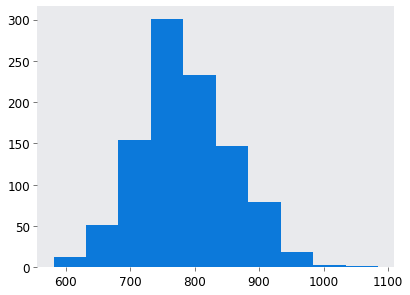

In [82]:
teff = 5700.
nu_max = 2853.

rng, *keys = random.split(rng, 5)

plt.figure()
# tau_he = 10**(np.ravel(he_pred["z_test_mean"] + he_pred["z_test_var"] * random.normal(keys[3], shape=(1000,))) + 6)
# plt.hist(tau_he);

teff_pred = np.log10(teff + 10.0 * random.normal(keys[1], shape=(1000,)))
nu_max_pred = np.log10(nu_max + 0.001*nu_max * random.normal(keys[0], shape=(1000,)))
xy_pred = jnp.stack([teff_pred, nu_max_pred], axis=-1)

diag = 0.2**2  # add this to diag of prediction (prediction in log space so this is ~ frac err)

he_pred = he_predictive(keys[2], xy, obs=sample["log_tau_he"].to_numpy() - 6, xy_test=xy_pred, diag=diag)

tau_he = 10**(np.ravel(he_pred["z_test_mean"] + he_pred["z_test_var"] * random.normal(keys[3], shape=(1000,))) + 6)
plt.hist(tau_he);

# tau_he += np.ravel(random.normal(keys[3], shape=(1000,)))
# plt.hist(tau_he, alpha=0.5);

In [54]:
conditioned_model = numpyro.handlers.lift(model, prior={
    "xy_test": dist.Normal(jnp.array([[teff, nu_max]]), jnp.array([[10.0, 0.001*nu_max]]))
})

In [55]:
he_predictive_cond = Predictive(conditioned_model, guide=guide, params=svi_result.params, num_samples=1000)

In [56]:
rng, key = random.split(rng)
he_cond = he_predictive_cond(key, xy, obs=sample["log_tau_he"].to_numpy() - 6, xy_test=0.0)

In [43]:
rng, key = random.split(rng)

svi_result = svi.run(key, 500, xy, obs=sample["log_tau_cz"].to_numpy() - 6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.73it/s, init loss: -1501.0260, avg. loss [476-500]: -2314.7995]


In [44]:
cz_predictive = Predictive(model, guide=guide, params=svi_result.params, num_samples=1)

In [45]:
x_grid, y_grid = jnp.linspace(jnp.array([3.6, 0.5]), jnp.array([3.9, 4.0]), 51, axis=1)
xx, yy = jnp.meshgrid(x_grid, y_grid)
xy_grid = jnp.stack([xx.flatten(), yy.flatten()], axis=-1)

In [46]:
rng, key = random.split(rng)

grid_pred = cz_predictive(key, xy, obs=sample["log_tau_cz"].to_numpy() - 6, xy_test=xy_grid)

In [47]:
tau_grid = jnp.squeeze(grid_pred["z_test_mean"]).reshape(xx.shape)
tau_grid.shape

(51, 51)

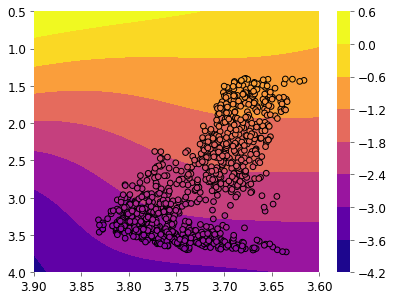

In [48]:
vmin = -4.0
vmax = 0.0

c = plt.contourf(
    xx, 
    yy, 
    tau_grid,
    vmin=vmin,
    vmax=vmax
)

s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["nu_max"]), 
    c=sample["log_tau_cz"].to_numpy() - 6,
    s=32,
    vmin=vmin,
    vmax=vmax,
    edgecolor="black"
    
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(c)

In [49]:
rng, key = random.split(rng)

test_pred = cz_predictive(key, xy, obs=sample["log_tau_cz"].to_numpy() - 6, xy_test=xy_test)

In [50]:
tau_test_mean = jnp.squeeze(test_pred["z_test_mean"])
tau_test_var = jnp.squeeze(test_pred["z_test_var"])

(array([ 16.,  64., 142., 220., 213., 171., 107.,  55.,   7.,   5.]),
 array([-0.05818974, -0.04453437, -0.03087899, -0.01722361, -0.00356824,
         0.01008714,  0.02374251,  0.03739789,  0.05105326,  0.06470864,
         0.07836402]),
 <BarContainer object of 10 artists>)

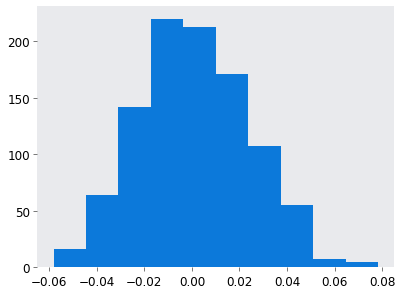

In [51]:
err = (tau_test_mean - test["log_tau_cz"].to_numpy() + 6)

plt.hist(np.ravel(err))

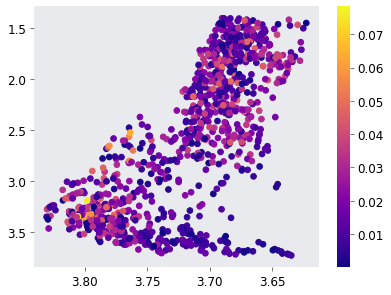

In [52]:
s = plt.scatter(
    np.log10(test["effective_T"]), 
    np.log10(test["nu_max"]), 
    c=abs(err),
    s=32,    
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(s)

In [53]:
sample.loc[(sample["effective_T"] > 6500.) & (sample["nu_max"] < 1500.), ["effective_T", "nu_max"]]

,effective_T,nu_max
689,6551.991786,1490.509488


In [54]:
sample.loc[578, "tau_cz"]

4979.743853233036

(array([  3.,  19.,  86., 208., 289., 257., 114.,  19.,   4.,   1.]),
 array([3.75314367, 3.75373971, 3.75433575, 3.75493179, 3.75552783,
        3.75612387, 3.75671991, 3.75731595, 3.75791199, 3.75850803,
        3.75910407]),
 <BarContainer object of 10 artists>)

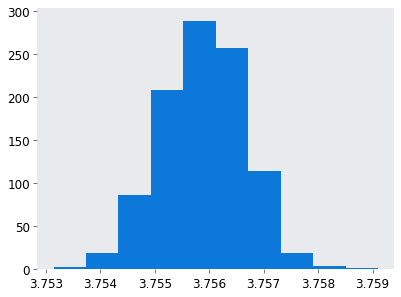

In [55]:
plt.hist(np.ravel(teff_pred))

In [31]:
teff = 5700.
nu_max = 2853.

normal = lambda key: random.normal(key, shape=(1000,))

rng, *keys = random.split(rng, 5)

teff_pred = np.log10(teff + 10 * normal(keys[0]))
nu_max_pred = np.log10(nu_max + 0.001*nu_max * normal(keys[1]))
xy_pred = jnp.stack([teff_pred, nu_max_pred], axis=-1)

he_pred = he_predictive(keys[2], xy, obs=sample["log_tau_he"].to_numpy() - 6, xy_test=xy_pred, diag=0.2**2)
cz_pred = cz_predictive(keys[3], xy, obs=sample["log_tau_cz"].to_numpy() - 6, xy_test=xy_pred, diag=0.2**2)

plt.figure()
log_tau_he = he_pred["z_test_mean"] + he_pred["z_test_var"] * normal(keys[2])
log_tau_cz = cz_pred["z_test_mean"] + cz_pred["z_test_var"] * normal(keys[3])
tau_he = 10**(np.ravel(log_tau_he) + 6)
tau_cz = 10**(np.ravel(log_tau_cz) + 6) 

plt.hist(tau_he)
plt.hist(tau_cz)

# mu = tau_he.mean()
# sigma = tau_he.std()
# # tau_he = mu + np.sqrt(sigma**2 + 0.01 * mu**2) * np.ravel(random.normal(keys[4], shape=(1000,)))
# tau_he += 0.1 * tau_he * np.ravel(random.normal(keys[4], shape=(1000,)))
# plt.hist(tau_he, alpha=0.5)


# tau_cz += 0.02 * tau_cz * np.ravel(random.normal(keys[5], shape=(1000,)))
# plt.hist(tau_cz, alpha=0.5)

NameError: name 'cz_predictive' is not defined

In [67]:
np.log10(tau_he).mean() - 6

-3.1029384258493473

In [68]:
np.log10(tau_he).std()

0.041896029582530345

In [65]:
np.log10(tau_cz).mean() - 6

-2.632014917582176

In [66]:
np.log10(tau_cz).std()

0.03946262278421482

In [15]:
nuts = NUTS(model, init_strategy=lambda site=None: numpyro.infer.init_to_median(site=site, num_samples=100))
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

In [ ]:
rng, key = random.split(rng)

mcmc.run(
    key,
    xy,
    obs=sample["log_tau_he"].to_numpy() - 6
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [603]:
rng, key = random.split(rng)

mcmc.run(
    key,
    sample["log_nu_max"].to_numpy(),
    tau_obs=sample["log_tau_he"].to_numpy() - 6
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        a[0]     -0.81      0.02     -0.81     -0.84     -0.78    421.49      1.01
        a[1]     -0.97      0.00     -0.97     -0.97     -0.97   1520.52      1.00
        b[0]     -0.33      0.06     -0.33     -0.43     -0.22    418.95      1.01
        b[1]      0.27      0.00      0.27      0.26      0.28   2285.91      1.00
         loc      3.35      0.01      3.35      3.33      3.37   1003.77      1.01
       scale      0.19      0.01      0.19      0.18      0.21    488.52      1.01
sigma_tau[0]      0.04      0.00      0.04      0.04      0.04   1035.78      1.01
sigma_tau[1]      0.02      0.00      0.02      0.02      0.02    425.99      1.01

Number of divergences: 0


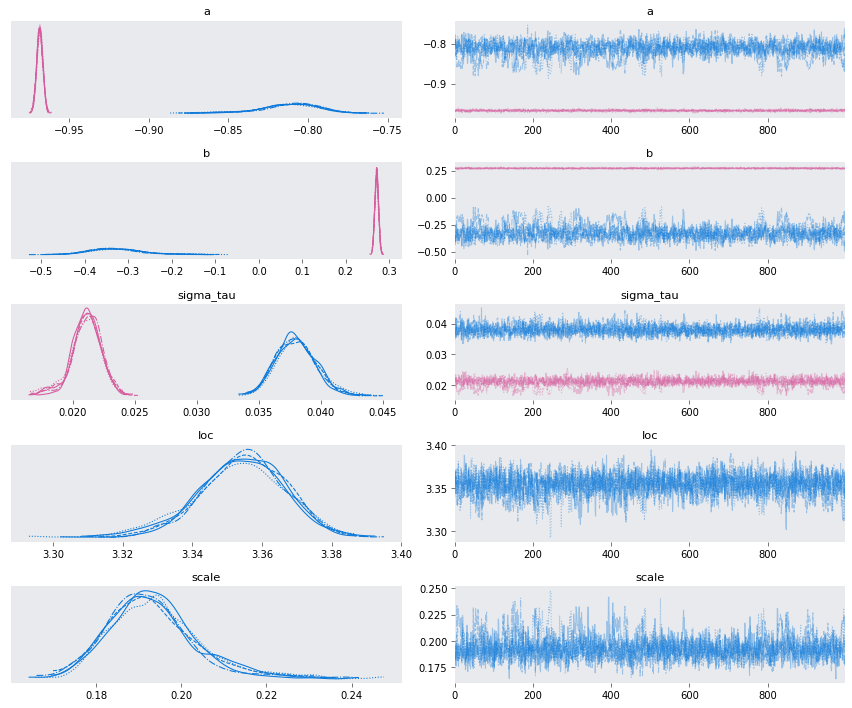

In [604]:
trace_tau_he = az.from_numpyro(mcmc)
az.plot_trace(trace_tau_he, var_names=["a", "b", "sigma_tau", "loc", "scale"], 
              backend_kwargs={"tight_layout": True});

In [605]:
he_samples = mcmc.get_samples()

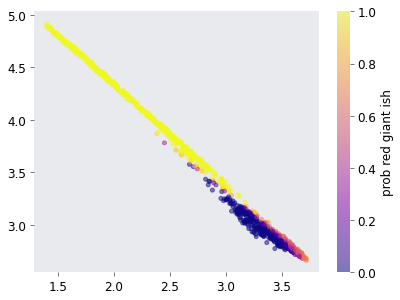

In [606]:
s = plt.scatter(sample["log_nu_max"], sample["log_tau_he"], c=he_samples["p_rg"].mean(axis=0), alpha=0.5)

plt.colorbar(s, label="prob red giant ish")

In [607]:
he_predictive = Predictive(model, posterior_samples=he_samples)

In [608]:
test = df.loc[mask].sample(100)

rng, key = random.split(rng)
test_pred = he_predictive(key, test["log_nu_max"].to_numpy())

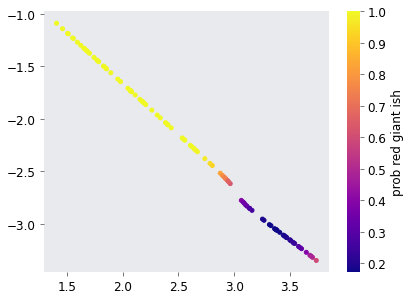

In [609]:
s = plt.scatter(test["log_nu_max"], np.median(test_pred["tau"], axis=0), c=np.median(test_pred["p_rg"], axis=0))

plt.colorbar(s, label="prob red giant ish")

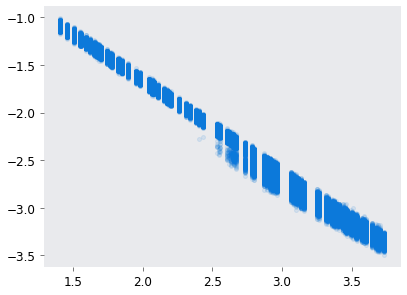

In [610]:
s = plt.scatter(np.broadcast_to(test["log_nu_max"], test_pred["tau"].shape), test_pred["tau"], alpha=0.1)

In [492]:
# var = 9.0
# scale = jnp.array([0.4, 5.7])
# off_diag = jnp.array(2.0)
# sigma = 0.01

# xy = jnp.log10(jnp.stack(
#     [
#         sample["effective_T"].to_numpy(),
#         sample["nu_max"].to_numpy()
#     ],
#     axis=-1
# ))

# kernel = var * transforms.Cholesky.from_parameters(
#         scale, off_diag, kernels.ExpSquared()
#     )

# gp = GaussianProcess(kernel, xy, diag=sigma**2)

In [34]:
# x_grid, y_grid = jnp.linspace(jnp.array([3.6, 0.5]), jnp.array([3.9, 4.0]), 51, axis=1)
# xx, yy = jnp.meshgrid(x_grid, y_grid)
# xy_grid = jnp.stack([xx.flatten(), yy.flatten()], axis=-1)

In [494]:
# _, gp_grid = gp.condition(
#     sample["log_tau_he"].to_numpy() - 6,
#     xy_grid
# )

In [495]:
vmin = -4.0
vmax = 0.0

c = plt.contourf(
    xx, 
    yy, 
    gp_grid.mean.reshape(xx.shape),
    vmin=vmin,
    vmax=vmax
)

s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["nu_max"]), 
    c=sample["log_tau_he"].to_numpy() - 6,
    s=32,
    vmin=vmin,
    vmax=vmax,
    edgecolor="black"
    
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(c)

In [496]:
# gp_grid.mean.reshape(xx.shape)

In [497]:
# test = df.loc[mask].sample(1000)

# xy_test = jnp.log10(jnp.stack(
#     [
#         test["effective_T"].to_numpy(),
#         test["nu_max"].to_numpy()
#     ],
#     axis=-1
# ))

In [498]:
# _, gp_test = gp.condition(
#     sample["log_tau_he"].to_numpy() - 6,
#     xy_test
# )

In [499]:
# err = abs(gp_test.mean - test["log_tau_he"] + 6)

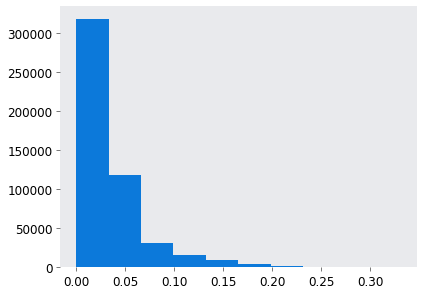

In [613]:
err = abs(test_pred["tau"] - test["log_tau_he"].to_numpy()[None, ...] + 6)
plt.hist(np.ravel(err));

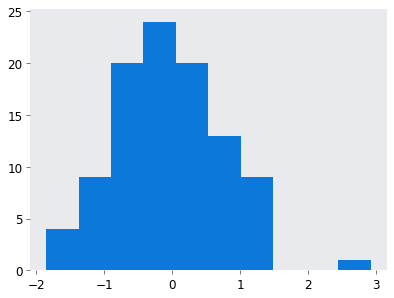

In [614]:
z = (test_pred["tau"].mean(axis=0) - test["log_tau_he"].to_numpy() + 6) / test_pred["tau"].std(axis=0)
plt.hist(np.ravel(z));

In [533]:
# s = plt.scatter(xy_test[:, 1], gp_test.mean, c=10**xy_test[:, 0])

# plt.colorbar(s)

In [534]:
# s = plt.scatter(
#     *xy_test.T,
#     c=err,
# )
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# # plt.axhline(np.log10(3090))
# # plt.axvline(np.log10(6500))
# plt.colorbar(s)

In [535]:
# gp.condition(
#     sample["log_tau_he"].to_numpy() - 6,
#     jnp.log10(jnp.array([[6649.4, 1499.1]]))
# ).gp.mean

In [536]:
idx = err.idxmax()
profile = get_profile(idx, test)

In [229]:
tau_he_pred = 10**(gp.condition(
    sample["log_tau_he"].to_numpy() - 6,
    jnp.log10(
        test.loc[idx, ["effective_T", "nu_max"]].astype(float).to_numpy()
    )[None, :]
).gp.mean + 6)

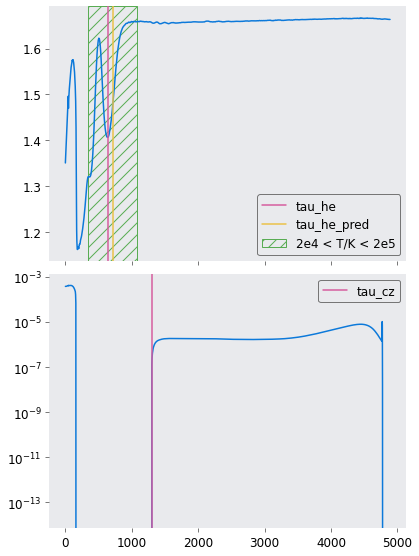

In [230]:
tau_he = test.loc[idx, "tau_he"]
tau_cz = test.loc[idx, "tau_cz"]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 9.6),
                               sharex=True, gridspec_kw={"hspace": 0.05})

ax1.plot(profile["tau"], profile["Gamma_1"])
ax1.axvline(tau_he, color="C1", label="tau_he")
ax1.axvline(tau_he_pred, color="C3", label="tau_he_pred")

ax1.axvspan(
    profile.loc[profile["T"] > 2e4, "tau"].iloc[-1],
    profile.loc[profile["T"] < 2e5, "tau"].iloc[0],
    facecolor="none",
    edgecolor="C2",
    hatch="//",
    label="2e4 < T/K < 2e5"
)
ax1.legend()
# ax1.grid(True)
ax2.plot(profile["tau"], profile["N^2"])
ax2.axvline(tau_cz, color="C1", label="tau_cz")

ax2.set_yscale("log")
ax2.legend();
# ax2.grid(True)

## BCZ

In [538]:
# rng, key = random.split(rng)

# mcmc.run(
#     key,
#     xy,
#     obs=sample["log_tau_cz"].to_numpy() - 6
# )
# mcmc.print_summary()

In [615]:
rng, key = random.split(rng)

mcmc.run(
    key,
    sample["log_nu_max"].to_numpy(),
    tau_obs=sample["log_tau_cz"].to_numpy() - 6
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        a[0]     -0.65      0.03     -0.65     -0.69     -0.61   2505.66      1.00
        a[1]     -0.88      0.00     -0.88     -0.89     -0.87   3449.60      1.00
        b[0]     -0.44      0.09     -0.44     -0.59     -0.30   2499.67      1.00
        b[1]      0.47      0.01      0.47      0.45      0.48   3512.28      1.00
         loc      3.36      0.01      3.36      3.34      3.38   4827.82      1.00
       scale      0.18      0.01      0.18      0.17      0.20   4787.57      1.00
sigma_tau[0]      0.08      0.00      0.08      0.07      0.08   5413.80      1.00
sigma_tau[1]      0.04      0.00      0.04      0.04      0.05   4295.90      1.00

Number of divergences: 0


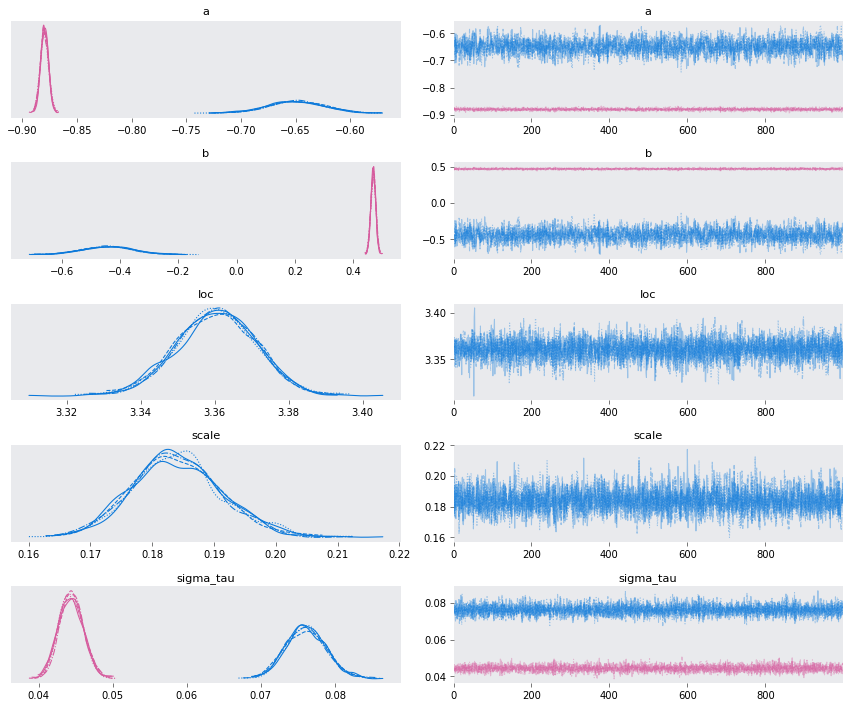

In [616]:
trace_tau_cz = az.from_numpyro(mcmc)
az.plot_trace(trace_tau_cz, var_names=["a", "b", "loc", "scale", "sigma_tau"], backend_kwargs={"tight_layout": True});

In [617]:
cz_samples = mcmc.get_samples()

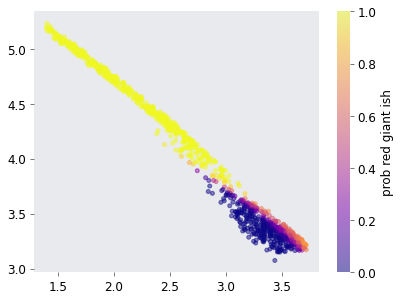

In [618]:
s = plt.scatter(sample["log_nu_max"], sample["log_tau_cz"], c=mcmc_samples["p_rg"].mean(axis=0), alpha=0.5)

plt.colorbar(s, label="prob red giant ish")

In [1]:
s = plt.scatter(sample["log_nu_max"], sample["log_tau_cz"], c=sample["effective_T"], alpha=0.5)

plt.colorbar(s, label="teff")

NameError: name 'plt' is not defined

In [619]:
cz_predictive = Predictive(model, posterior_samples=mcmc.get_samples())

In [620]:
rng, key = random.split(rng)
test_pred = cz_predictive(key, test["log_nu_max"].to_numpy())

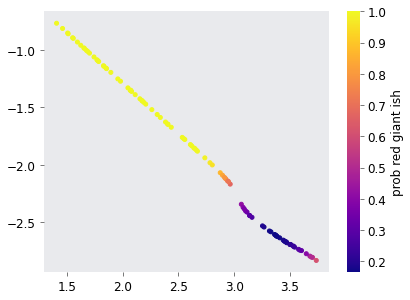

In [621]:
s = plt.scatter(test["log_nu_max"], np.median(test_pred["tau"], axis=0), c=np.median(test_pred["p_rg"], axis=0))

plt.colorbar(s, label="prob red giant ish")

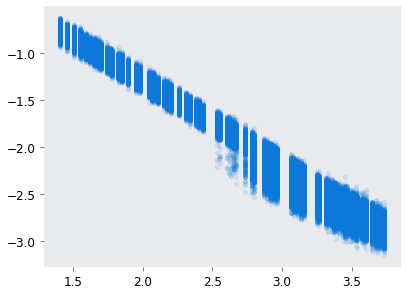

In [622]:
s = plt.scatter(np.broadcast_to(test["log_nu_max"], test_pred["tau"].shape), test_pred["tau"], alpha=0.1)

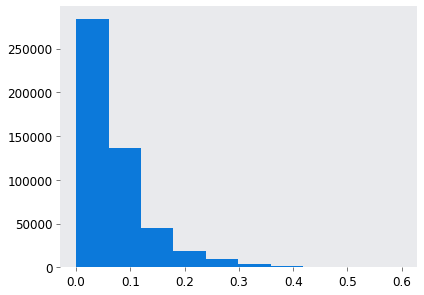

In [623]:
err = abs(test_pred["tau"] - test["log_tau_cz"].to_numpy()[None, ...] + 6)
plt.hist(np.ravel(err));

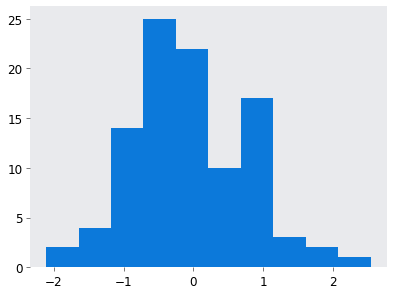

In [624]:
z = (test_pred["tau"].mean(axis=0) - test["log_tau_cz"].to_numpy() + 6) / test_pred["tau"].std(axis=0)
plt.hist(np.ravel(z));

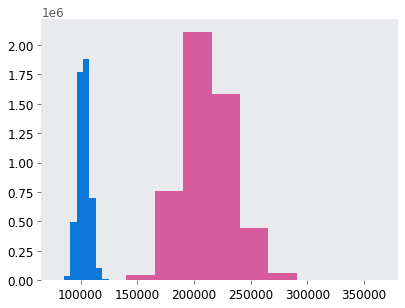

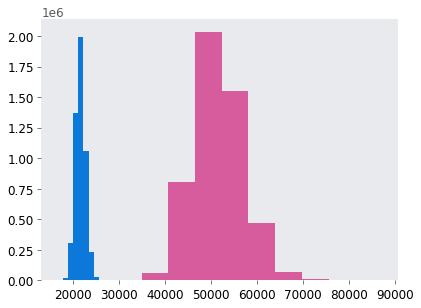

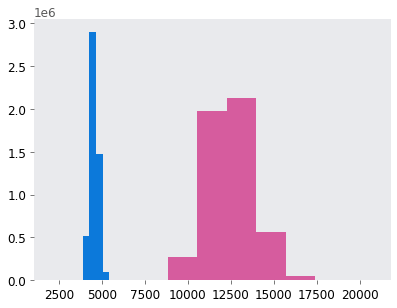

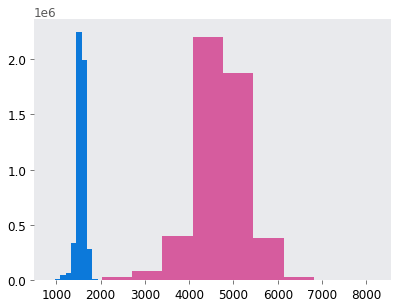

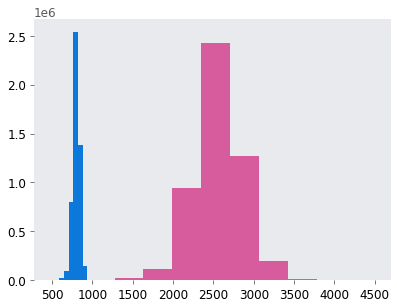

In [627]:
for a in [20., 100., 500., 1500., 3000.]:
    rng, *keys = random.split(rng, 4)

    nu_max_pred = np.log10(a + 0.01*a * random.normal(keys[0], shape=(1000,)))

    he_pred = he_predictive(keys[1], nu_max_pred)
    cz_pred = cz_predictive(keys[2], nu_max_pred)
    
    plt.figure()
    plt.hist(10**(np.ravel(he_pred["tau"])+6))
    plt.hist(10**(np.ravel(cz_pred["tau"])+6))

In [233]:
var = 7.9
scale = jnp.array([0.4, 4.3])
off_diag = jnp.array(1.9)
sigma = 0.02
kernel = var * transforms.Cholesky.from_parameters(
        scale, off_diag, kernels.ExpSquared()
    )

# subsample = df.loc[mask].sample(500)
# _xy = jnp.log10(jnp.stack(
#     [
#         subsample["effective_T"].to_numpy(),
#         subsample["nu_max"].to_numpy()
#     ],
#     axis=-1
# ))

gp = GaussianProcess(kernel, xy,
                     diag=sigma**2
                    )

Let's condition on a larger sample

In [234]:
_, gp_grid = gp.condition(
#     subsample["log_tau_cz"].to_numpy() - 6,
    sample["log_tau_cz"].to_numpy() - 6,
    xy_grid
)

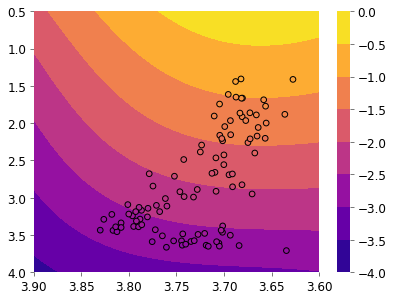

In [235]:
vmin = -4.0
vmax = 0.0

c = plt.contourf(
    xx, 
    yy, 
    gp_grid.mean.reshape(xx.shape),
    vmin=vmin,
    vmax=vmax
)

s = plt.scatter(
    *xy.T,
    c=sample["log_tau_cz"].to_numpy() - 6,
    s=32,
    vmin=vmin,
    vmax=vmax,
    edgecolor="black"
    
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(c)

In [236]:
_, gp_test = gp.condition(
#     subsample["log_tau_cz"].to_numpy() - 6,
    sample["log_tau_cz"].to_numpy() - 6,
    xy_test
)

In [237]:
err = abs(gp_test.mean - test["log_tau_cz"] + 6)

(array([289., 267., 200., 132.,  73.,  24.,   7.,   4.,   1.,   3.]),
 array([9.51970305e-06, 9.59312058e-03, 1.91767215e-02, 2.87603223e-02,
        3.83439232e-02, 4.79275241e-02, 5.75111249e-02, 6.70947258e-02,
        7.66783267e-02, 8.62619276e-02, 9.58455284e-02]),
 <BarContainer object of 10 artists>)

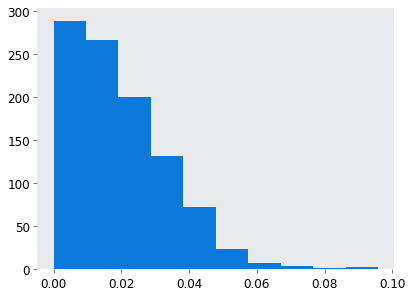

In [238]:
plt.hist(err)

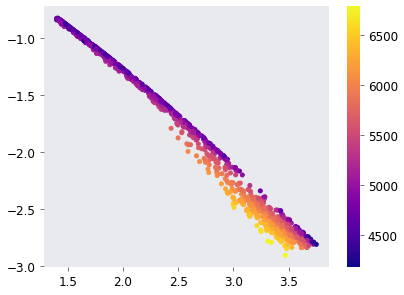

In [239]:
s = plt.scatter(xy_test[:, 1], gp_test.mean, c=10**xy_test[:, 0])

plt.colorbar(s)

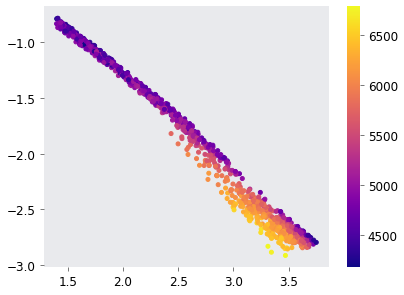

In [246]:
s = plt.scatter(xy_test[:, 1], test["log_tau_cz"] - 6, c=10**xy_test[:, 0])

plt.colorbar(s)

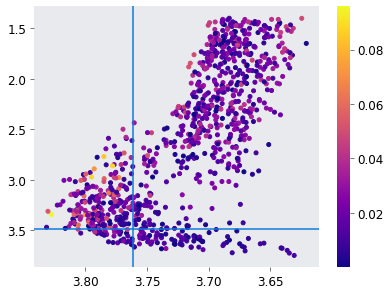

In [245]:
s = plt.scatter(
    *xy_test.T,
    c=err,
)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axhline(np.log10(3090))
plt.axvline(np.log10(5777))
plt.colorbar(s)

In [162]:
gp.condition(
    sample["log_tau_cz"].to_numpy() - 6,
    jnp.log10(jnp.array([[6649.4, 1499.1]]))
).gp.mean

DeviceArray([-2.64347839], dtype=float64)

In [241]:
idx = err.idxmax()
profile = get_profile(idx, test)

In [242]:
tau_cz_pred = 10**(gp.condition(
    sample["log_tau_cz"].to_numpy() - 6,
    jnp.log10(
        test.loc[idx, ["effective_T", "nu_max"]].astype(float).to_numpy()
    )[None, :]
).gp.mean + 6)

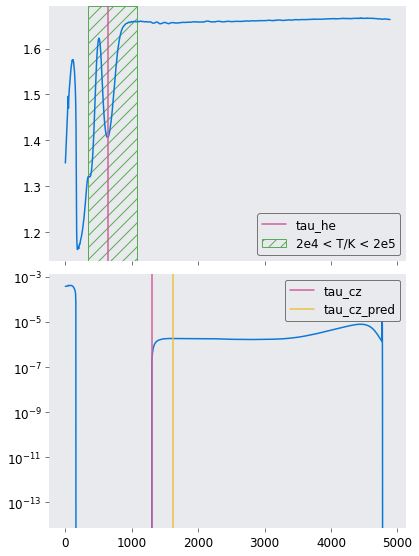

In [244]:
tau_he = test.loc[idx, "tau_he"]
tau_cz = test.loc[idx, "tau_cz"]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 9.6),
                               sharex=True, gridspec_kw={"hspace": 0.05})

ax1.plot(profile["tau"], profile["Gamma_1"])
ax1.axvline(tau_he, color="C1", label="tau_he")

ax1.axvspan(
    profile.loc[profile["T"] > 2e4, "tau"].iloc[-1],
    profile.loc[profile["T"] < 2e5, "tau"].iloc[0],
    facecolor="none",
    edgecolor="C2",
    hatch="//",
    label="2e4 < T/K < 2e5"
)
ax1.legend()
# ax1.grid(True)
ax2.plot(profile["tau"], profile["N^2"])
ax2.axvline(tau_cz, color="C1", label="tau_cz")
ax2.axvline(tau_cz_pred, color="C3", label="tau_cz_pred")

ax2.set_yscale("log")
ax2.legend();
# ax2.grid(True)

OLD

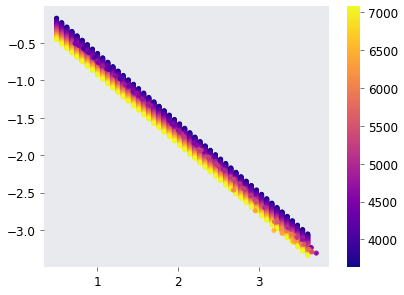

In [200]:
xmin, xmax = (3.56, 3.85)
x = np.linspace(xmin, xmax)
y = np.linspace(0.5, 3.6)

xx, yy = np.meshgrid(x, y)

# zz = 0.27 - 0.98 * yy.flatten()
# zz = 0.2 + (0.37 - 0.36 * xx.flatten()) * yy.flatten()
zz = 3.82 - 0.99 * xx.flatten() - 0.93 * yy.flatten()

s = plt.scatter(yy, zz, c=10**xx, vmin=10**xmin, vmax=10**xmax)

s = plt.scatter(
    np.log10(sample["nu_max"]), 
    sample["log_tau_he"]-6, 
    c=sample["effective_T"], 
    vmin=10**xmin, 
    vmax=10**xmax,
#     edgecolors="black"
)
plt.colorbar(s)


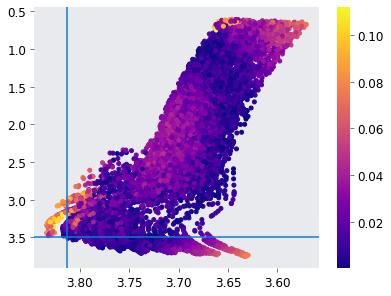

In [11]:
# tau_pred = 0.2 + (0.37 - 0.36 * np.log10(sample["effective_T"])) * np.log10(sample["nu_max"])
# tau_pred = 0.27 - 0.98 * np.log10(sample["nu_max"])
tau_pred = 3.82 - 0.99 * np.log10(sample["effective_T"]) - 0.93 * np.log10(sample["nu_max"])

err = abs(sample["log_tau_he"] - 6 - tau_pred)
s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["nu_max"]), 
    c=err,
)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axhline(np.log10(3090))
plt.axvline(np.log10(6500))
plt.colorbar(s)

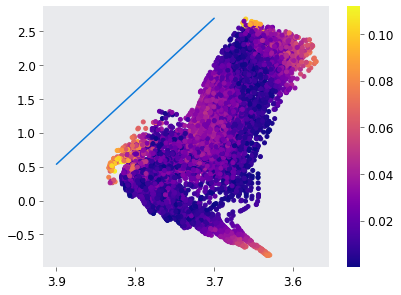

In [12]:
# tau_pred = 0.2 + (0.37 - 0.36 * np.log10(sample["effective_T"])) * np.log10(sample["nu_max"])
s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["luminosity"]), 
    c=err,
)

x = np.linspace(3.7, 3.9)
y = (np.log10(8907) - x) / 0.093  # red edge of the instabiility strip
plt.plot(x, y)

plt.gca().invert_xaxis()


plt.colorbar(s)

(array([3071., 2786., 2262., 1245.,  303.,  144.,  102.,   49.,   24.,
          14.]),
 array([1.17062409e-06, 1.11826711e-02, 2.23641716e-02, 3.35456720e-02,
        4.47271725e-02, 5.59086729e-02, 6.70901734e-02, 7.82716739e-02,
        8.94531743e-02, 1.00634675e-01, 1.11816175e-01]),
 <BarContainer object of 10 artists>)

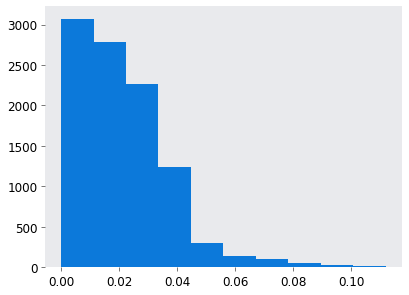

In [13]:
plt.hist(err)

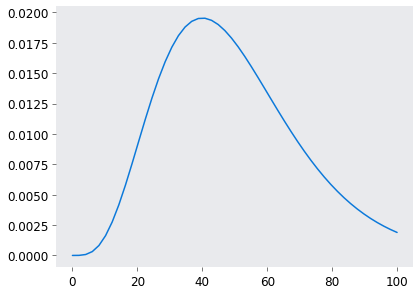

In [80]:
x = np.linspace(0, 100)
p = np.exp(dist.Gamma(5.0, 0.1).log_prob(x))
plt.plot(x, p)

In [87]:
def linear_model_cross(x, y, z=None):
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(3), 10.0))
    nu = numpyro.sample("nu", dist.Gamma(5.0, 0.1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))
    
    # mu = b0 + b1 * log_teff + (b2 + b3 Theta(log_numax - c)) log_numax
#     mu = beta[0] + beta[1] * x + (beta[2] + beta[3] * jnp.heaviside(y - gamma, 0.5)) * y
    mu = beta[0] + (beta[1] + beta[2] * x) * y
    numpyro.sample("z", dist.StudentT(nu, mu, sigma), obs=z)

In [88]:
nuts = NUTS(linear_model_2d_T)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

In [89]:
rng, key = random.split(rng)
mcmc.run(
    key,
    np.log10(sample["effective_T"].to_numpy()),
    np.log10(sample["nu_max"].to_numpy()),
    z=sample["log_tau_cz"].to_numpy() - 6
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      6.68      0.06      6.68      6.58      6.79   1226.78      1.00
   beta[1]     -1.73      0.02     -1.73     -1.76     -1.70   1227.91      1.00
   beta[2]     -0.81      0.00     -0.81     -0.81     -0.81   1754.76      1.00
        nu     98.16     25.39     95.28     57.87    136.59   2306.61      1.00
     sigma      0.06      0.00      0.06      0.06      0.06   2936.81      1.00

Number of divergences: 0


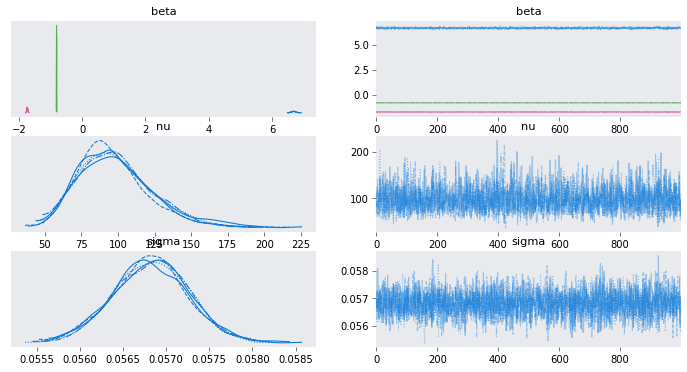

In [90]:
trace_tau_cz = az.from_numpyro(mcmc)
az.plot_trace(trace_tau_cz);

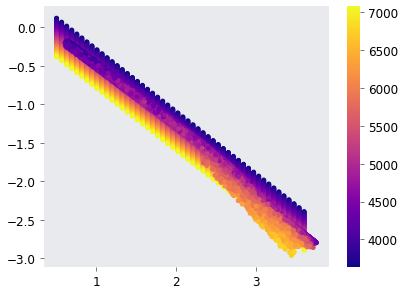

In [91]:
xmin, xmax = (3.56, 3.85)
x = np.linspace(xmin, xmax)
y = np.linspace(0.5, 3.6)

xx, yy = np.meshgrid(x, y)


# zz = 0.29 + (1.92 - 0.74 * xx.flatten()) * yy.flatten()
zz = 6.68 - 1.73 * xx.flatten() - 0.81 * yy.flatten()

s = plt.scatter(yy, zz, c=10**xx, vmin=10**xmin, vmax=10**xmax)
s = plt.scatter(
    np.log10(sample["nu_max"]), 
    sample["log_tau_cz"] - 6, 
    c=sample["effective_T"],
    vmin=10**xmin,
    vmax=10**xmax,
#     edgecolors="black"
)

plt.colorbar(s)


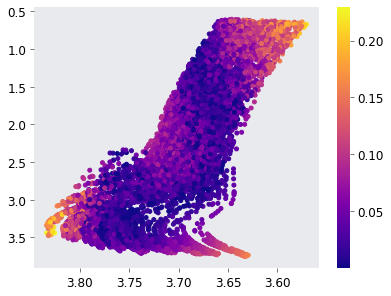

In [94]:
# tau_pred = 0.29 + (1.92 - 0.74 * np.log10(sample["effective_T"])) *np.log10(sample["nu_max"])
tau_pred = 6.68 - 1.73 * np.log10(sample["effective_T"]) - 0.81 * np.log10(sample["nu_max"])


err = abs(sample["log_tau_cz"] - 6 - tau_pred)
s = plt.scatter(
    np.log10(sample["effective_T"]), 
    np.log10(sample["nu_max"]), 
    c=err,
)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.colorbar(s)

(array([3134., 2652., 1877., 1132.,  574.,  314.,  202.,   85.,   20.,
          10.]),
 array([6.73880030e-06, 2.29190724e-02, 4.58314060e-02, 6.87437395e-02,
        9.16560731e-02, 1.14568407e-01, 1.37480740e-01, 1.60393074e-01,
        1.83305407e-01, 2.06217741e-01, 2.29130075e-01]),
 <BarContainer object of 10 artists>)

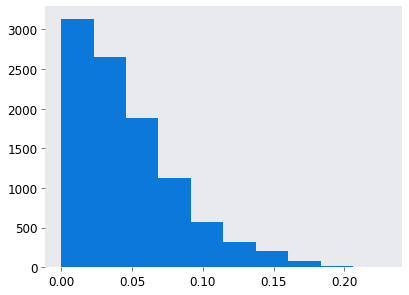

In [95]:
plt.hist(err)

In [99]:
from scipy import stats

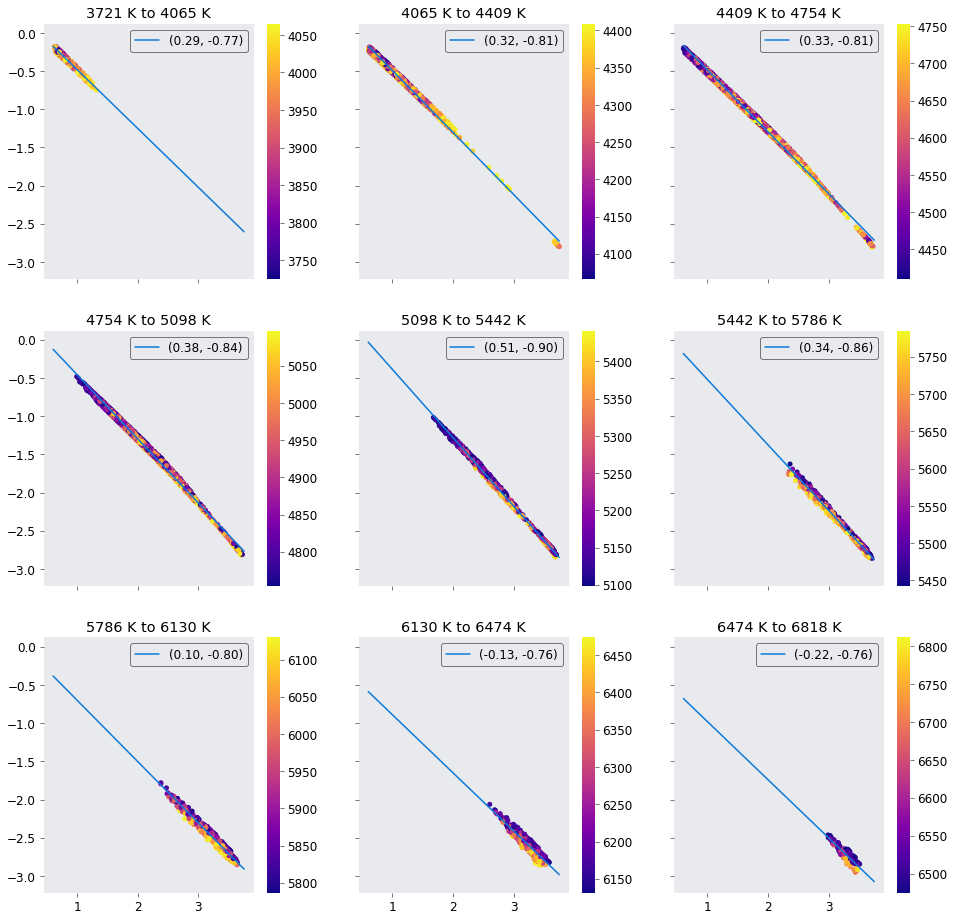

In [103]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=True, sharey=True)

teff_min = sample["effective_T"].min()
teff_max = sample["effective_T"].max()
delta_teff = (teff_max - teff_min) / axes.size

for i, ax in enumerate(axes.flatten()):
    
    minimum = teff_min + i*delta_teff
    maximum = teff_min + (i+1)*delta_teff
    mask = (sample["effective_T"] > minimum) & \
        (sample["effective_T"] < maximum)
    result = stats.linregress(
        np.log10(sample.loc[mask, "nu_max"]),
        sample.loc[mask, "log_tau_cz"] - 6
    )
    
    s = ax.scatter(
        np.log10(sample.loc[mask, "nu_max"]), 
        sample.loc[mask, "log_tau_cz"] - 6, 
        c=sample.loc[mask, "effective_T"],
    )
    x = np.log10(np.linspace(sample["nu_max"].min(), sample["nu_max"].max()))
    y = result.intercept + result.slope * x
    ax.plot(
        x,
        y,
        label=f"({result.intercept:.2f}, {result.slope:.2f})"
    )
    ax.set_title(f"{minimum:.0f} K to {maximum:.0f} K")
    ax.legend()
    fig.colorbar(s, ax=ax)


TODO: use step function for gradient in nu_max

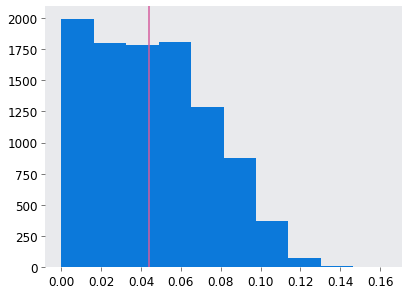

In [77]:
plt.hist(err)
plt.axvline(np.median(err), c="C1")